In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

import matplotlib.pyplot as plt

In [4]:
expected_cols = {"userid", "version", "sum_gamerounds", "retention_1", "retention_7"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

print(df.dtypes)
print(df.isna().sum())

# Check random assignment balance
df["version"].value_counts()


userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [5]:
CONTROL = "gate_30"
TREAT = "gate_40"

def two_proportion_test(df, metric_col, control=CONTROL, treat=TREAT, alpha=0.05):

    tmp = df.copy()

    # Ensure 0/1
    if tmp[metric_col].dtype == bool:
        tmp[metric_col] = tmp[metric_col].astype(int)

    g = tmp.groupby("version")[metric_col].agg(["sum", "count"]).rename(columns={"sum":"successes","count":"n"})
    s_c, n_c = int(g.loc[control, "successes"]), int(g.loc[control, "n"])
    s_t, n_t = int(g.loc[treat, "successes"]), int(g.loc[treat, "n"])

    p_c = s_c / n_c
    p_t = s_t / n_t

    # Two-proportion z-test (H0: p_t = p_c)
    zstat, pval = proportions_ztest([s_t, s_c], [n_t, n_c], alternative="two-sided")

    # CI for difference in proportions (treat - control)
    ci_low, ci_high = confint_proportions_2indep(
        count1=s_t, nobs1=n_t,
        count2=s_c, nobs2=n_c,
        method="wald"  # simple; we’ll also do bootstrap later
    )

    abs_lift = p_t - p_c
    rel_lift = abs_lift / p_c if p_c != 0 else np.nan

    return {
        "metric": metric_col,
        "n_control": n_c, "n_treat": n_t,
        "rate_control": p_c, "rate_treat": p_t,
        "abs_lift": abs_lift, "rel_lift": rel_lift,
        "p_value": pval,
        "ci_low": ci_low, "ci_high": ci_high,
    }

In [6]:
ret1 = two_proportion_test(df, "retention_1")
ret7 = two_proportion_test(df, "retention_7")

results = pd.DataFrame([ret1, ret7])
results

,metric,n_control,n_treat,rate_control,rate_treat,abs_lift,rel_lift,p_value,ci_low,ci_high
0,retention_1,44700,45489,0.448188,0.442283,-0.005905,-0.013176,0.074410,-0.012392,0.000582
1,retention_7,44700,45489,0.190201,0.182000,-0.008201,-0.043119,0.001554,-0.013282,-0.003121


In [7]:
def bootstrap_lift(df, metric_col, n_boot=5000, seed=42, control=CONTROL, treat=TREAT):
    rng = np.random.default_rng(seed)
    tmp = df.copy()

    if tmp[metric_col].dtype == bool:
        tmp[metric_col] = tmp[metric_col].astype(int)

    lifts = []
    for _ in range(n_boot):
        sample = tmp.sample(n=len(tmp), replace=True, random_state=int(rng.integers(0, 1_000_000_000)))
        rates = sample.groupby("version")[metric_col].mean()
        lifts.append(rates[treat] - rates[control])

    lifts = np.array(lifts)
    return lifts

boot_ret7 = bootstrap_lift(df, "retention_7", n_boot=5000)

ci = np.quantile(boot_ret7, [0.025, 0.975])
prob_positive = (boot_ret7 > 0).mean()

print("Bootstrap 95% CI (retention_7 lift):", ci)
print("P(lift > 0):", prob_positive)

Bootstrap 95% CI (retention_7 lift): [-0.01327754 -0.00316192]
P(lift > 0): 0.001


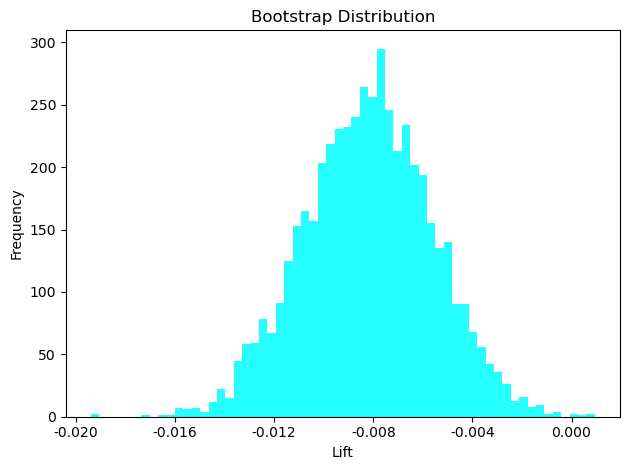

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.figure()
plt.hist(boot_ret7, bins=60, color="#00FFFF", alpha=0.85)
plt.title("Bootstrap Distribution")
plt.xlabel("Lift")
plt.ylabel("Frequency")
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
plt.tight_layout()
plt.savefig("figures/bootstrap_distribution.png", dpi=300, bbox_inches="tight")

plt.show()

In [9]:
g = df.groupby("version")["sum_gamerounds"]
summary = g.agg(["count", "mean", "median", "std", "min", "max"]).reset_index()
summary

,version,count,mean,median,std,min,max
0,gate_30,44700,52.456264,17.0,256.716423,0,49854
1,gate_40,45489,51.298776,16.0,103.294416,0,2640


Mann–Whitney U p-value: 0.05020880772044255


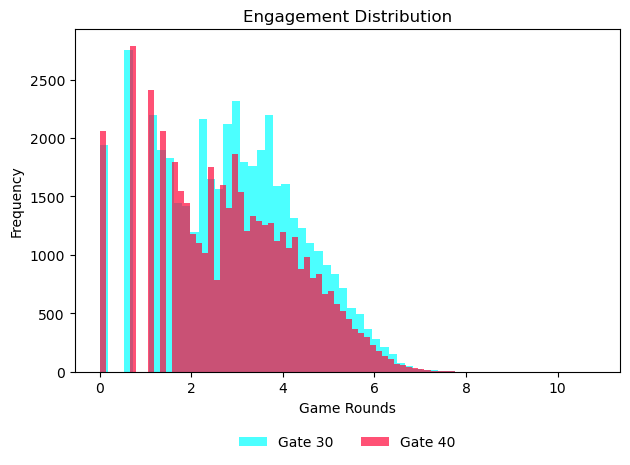

In [16]:
control_vals = df.loc[df["version"] == CONTROL, "sum_gamerounds"]
treat_vals   = df.loc[df["version"] == TREAT,   "sum_gamerounds"]

# Mann–Whitney U (non-parametric difference in distribution)
u_stat, p_u = stats.mannwhitneyu(treat_vals, control_vals, alternative="two-sided")
print("Mann–Whitney U p-value:", p_u)

plt.figure()
plt.hist(np.log1p(control_vals), bins=60, alpha=0.7, label="Gate 30", color="#00FFFF")
plt.hist(np.log1p(treat_vals), bins=60, alpha=0.7,  label="Gate 40", color="#FF073A")
plt.title("Engagement Distribution")
plt.xlabel("Game Rounds")
plt.ylabel("Frequency")
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    fontsize=10
)
plt.tight_layout()
plt.savefig("figures/engagement_distribution_log1p.png", dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
#from pathlib import Path
#Path("data/processed").mkdir(parents=True, exist_ok=True)

#results.to_csv("data/processed/ab_retention_results.csv", index=False)

#summary.to_csv("data/processed/ab_engagement_summary.csv", index=False)

# Bootstrap distribution (useful for Power BI charts)
#pd.DataFrame({"boot_lift_retention_7": boot_ret7}).to_csv(
#   "data/processed/bootstrap_retention_7_lift.csv", index=False)

#print("Exported to data/processed/")

Exported to data/processed/
